In [18]:
!pip install transformers
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
df_fake = pd.read_csv('Fake.csv')
df_real = pd.read_csv('True.csv')
df_fake['fake'] = 1
df_real['fake'] = 0
df = pd.concat([df_fake, df_real], axis=0)
df = shuffle(df).reset_index(drop=True)
df.head(2)

title  \
0                         Hurricane Irma will 'devastate' part of U.S.: emergency services head   
1  Daniel Greenfield: Why Obama Really Spied On Trump: ‘It’s not just ideology. It’s raw fear.’   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [20]:
df.shape

(44898, 5)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['fake'],axis=1), df['fake'], test_size=0.2, random_state=0)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 1
# train the whole model
for param in model.parameters():
    param.requires_grad = False

# add three new layers at the end of the network
model.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

model = model.to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
def preprocess_text(text):
    parts = []
    text_len = len(text.split(' '))
    delta = 300
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

In [23]:
train_data = pd.concat([X_train, y_train], axis=1).reset_index()

print_every = 300

total_loss = 0
all_losses = []

CUDA_LAUNCH_BLOCKING=1

model.train()

for idx, row in train_data.iterrows():
    text_parts = preprocess_text(str(row['text']))
    label = torch.tensor([row['fake']]).long().to(device)

    optimizer.zero_grad()

    overall_output = torch.zeros((1, 2)).float().to(device)
    for part in text_parts:
        if len(part) > 0:
            try:
                input = part.reshape(-1)[:512].reshape(1, -1)
                # print(input.shape)
                overall_output += model(input, labels=label)[1].float().to(device)
            except Exception as e:
                print(str(e))

#     overall_output /= len(text_parts)
    overall_output = F.softmax(overall_output[0], dim=-1)

    if label == 0:
        label = torch.tensor([1.0, 0.0]).float().to(device)
    elif label == 1:
        label = torch.tensor([0.0, 1.0]).float().to(device)

    # print(overall_output, label)

    loss = criterion(overall_output, label)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    if idx % print_every == 0 and idx > 0:
        average_loss = total_loss / print_every
        print("{}/{}. Average loss: {}".format(idx, len(train_data), average_loss))
        all_losses.append(average_loss)
        total_loss = 0

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


300/35918. Average loss: 0.2455265097071727
600/35918. Average loss: 0.2331909940391779
900/35918. Average loss: 0.20708012462904055
1200/35918. Average loss: 0.19961484629505624
1500/35918. Average loss: 0.1453339591016993
1800/35918. Average loss: 0.15940541809832212
2100/35918. Average loss: 0.13686978284502402
2400/35918. Average loss: 0.12172204799079434
2700/35918. Average loss: 0.1227492708452822
3000/35918. Average loss: 0.11230084976482127
3300/35918. Average loss: 0.10584874952396603
3600/35918. Average loss: 0.08914518657454512
3900/35918. Average loss: 0.107317527859171
4200/35918. Average loss: 0.0826079903903883
4500/35918. Average loss: 0.099260547241729
4800/35918. Average loss: 0.07878864411596927
5100/35918. Average loss: 0.08704285294529351
5400/35918. Average loss: 0.08919203329420876
5700/35918. Average loss: 0.09227990002659225
6000/35918. Average loss: 0.07898260863366886
6300/35918. Average loss: 0.08399963612259247
6600/35918. Average loss: 0.07592441972781672


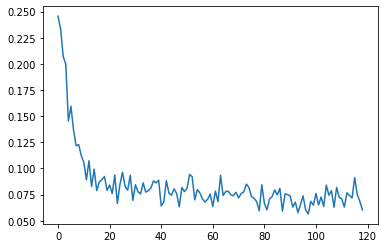

In [24]:
torch.save(model.state_dict(), "model_after_train.pt")
plt.plot(all_losses)


In [25]:
test_data = pd.concat([X_test, y_test], axis=1).reset_index()

total = len(test_data)
number_right = 0
model.eval()
with torch.no_grad():
    for idx, row in test_data.iterrows():
        text_parts = preprocess_text(str(row['text']))
        label = torch.tensor([row['fake']]).float().to(device)
        
        overall_output = torch.zeros((1,2)).to(device) 
        for part in text_parts:
            if len(part) > 0:
                overall_output += model(part.reshape(1, -1))[0]

            
        overall_output = F.softmax(overall_output[0], dim=-1)
            
        result = overall_output.max(0)[1].float().item()
 
        if result == label.item():
            number_right += 1
            
        if idx % print_every == 0 and idx > 0:
            print("{}/{}. Current accuracy: {}".format(idx, total, number_right / idx))
            
print("Accuracy on test data: {}".format(number_right / total))

300/8980. Current accuracy: 0.9633333333333334
600/8980. Current accuracy: 0.965
900/8980. Current accuracy: 0.9655555555555555
1200/8980. Current accuracy: 0.9633333333333334
1500/8980. Current accuracy: 0.964
1800/8980. Current accuracy: 0.9655555555555555
2100/8980. Current accuracy: 0.9666666666666667
2400/8980. Current accuracy: 0.9666666666666667
2700/8980. Current accuracy: 0.9644444444444444
3000/8980. Current accuracy: 0.965
3300/8980. Current accuracy: 0.9645454545454546
3600/8980. Current accuracy: 0.9644444444444444
3900/8980. Current accuracy: 0.9658974358974359
4200/8980. Current accuracy: 0.9657142857142857
4500/8980. Current accuracy: 0.9653333333333334
4800/8980. Current accuracy: 0.9660416666666667
5100/8980. Current accuracy: 0.9645098039215686
5400/8980. Current accuracy: 0.9648148148148148
5700/8980. Current accuracy: 0.964561403508772
6000/8980. Current accuracy: 0.964
6300/8980. Current accuracy: 0.9647619047619047
6600/8980. Current accuracy: 0.9651515151515152


1. Whole model trained:
  - train average loss: 0.07151
  - test accuracy: 0.96

2. Classifier-only trained:
  - train average loss: 0.06468
  - test accuracy: 0.96